In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
# Replace 'electron_flux_data.csv' with the path to your CSV file
df = pd.read_csv('C:\\Users\\shahi\\OneDrive\\Desktop\\Fatema_NASA\\Van_Allen\\3_days_electron_flux.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()


,time_tag,satellite,flux,energy
0,2024-08-25T12:10:00Z,16,43.201927,>=2 MeV
1,2024-08-25T12:15:00Z,16,9.090318,>=2 MeV
2,2024-08-25T12:20:00Z,16,123.123161,>=2 MeV
3,2024-08-25T12:25:00Z,16,136.516174,>=2 MeV
4,2024-08-25T12:30:00Z,16,4.000000,>=2 MeV


In [9]:
# Print the column names to check for typos or discrepancies
print(df.columns)


Index(['satellite', 'flux', 'energy'], dtype='object')


In [10]:
# Simulate a time index assuming data is in regular intervals (e.g., every 5 minutes)
df['time_tag'] = pd.date_range(start='2024-08-25T12:10:00Z', periods=len(df), freq='5T')
df.set_index('time_tag', inplace=True)


C:\Users\shahi\AppData\Local\Temp\ipykernel_9836\1752378155.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_tag'] = pd.date_range(start='2024-08-25T12:10:00Z', periods=len(df), freq='5T')


In [11]:
# Handle missing values in the 'flux' column
imputer = SimpleImputer(strategy='mean')
df['flux'] = imputer.fit_transform(df[['flux']])

# Normalize the 'flux' column
scaler = MinMaxScaler()
df['flux_scaled'] = scaler.fit_transform(df[['flux']])


In [12]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Adjust based on your data frequency

# Create sequences
X, y = create_sequences(df['flux_scaled'].values, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


C:\Users\shahi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0537 - val_loss: 0.0204
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0319 - val_loss: 0.0095
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0286 - val_loss: 0.0055
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0244 - val_loss: 0.0035
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0261 - val_loss: 0.0037
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0300 - val_loss: 0.0042
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0302 - val_loss: 0.0032
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0268 - val_loss: 0.0042
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0270 - val_loss: 0.0035
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0250 - val_loss: 0.0036
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0283 - val_loss: 0.0036
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step


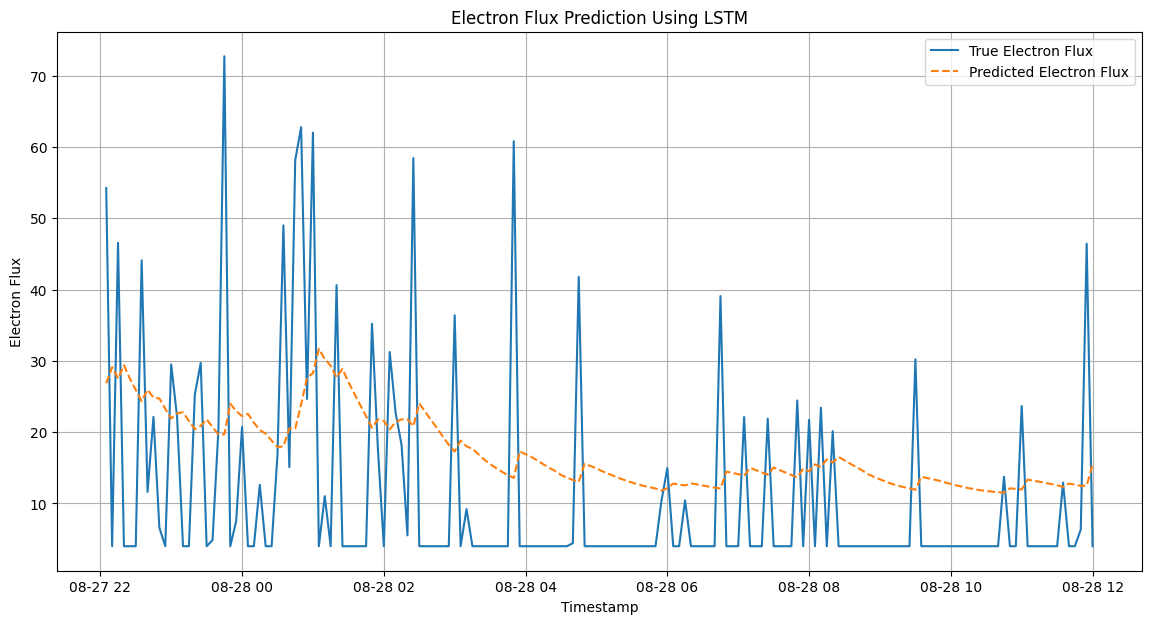

In [14]:
# Predict on the test data
y_pred = model.predict(X_test)

# Rescale the predictions and actual values back to original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label='True Electron Flux')
plt.plot(df.index[-len(y_test):], y_pred_rescaled, label='Predicted Electron Flux', linestyle='--')
plt.title('Electron Flux Prediction Using LSTM')
plt.xlabel('Timestamp')
plt.ylabel('Electron Flux')
plt.legend()
plt.grid(True)
plt.show()
